<h2>ARTIFICIAL INTELLIGENCE FOUNDAMENTALS PROJECT 2023-24</h2>

<h4><span style="color:lightblue">Github link</span>: https://github.com/tommasoDR/AIF-23-Project</h4>


<a href="https://colab.research.google.com/github/tommasoDR/AIF-23-Project/blob/testing/notebooks/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>INTRODUCTION</h3>

<h5>This project is centered around developing intelligent algorithms for agents to navigate through partially observable environments with optimal reasoning. The primary focus involves implementing an advanced exploration algorithm, based on A*, to enable the agent to effectively address our objectives. The agent's goal is to navigate sensibly within randomly generated rooms. It has to identify specific objects to recognize different room types, locate the target object and reach it. We used NetHack as the foundational framework for this project, offering a rich and complex environment for the development and testing of intelligent exploration algorithms.<br>
In the following we’re going to explain the algorithms, the heuristics and the optimizations that let the  agent to solve smartly this simple task on a random generated map in MiniHack environment.</h5>


<h3>RELATED WORKS</h3>
<h5>
For generating the random environment in which the agent perform our smart algorithms we used MiniHack and gym libraries.<br>
MiniHack (2) is a software tool tailored for AI experimentation. It provides a simplified version of NetHack Learning Environment (NLE) with reduced complexity. It offers a controlled environment for training and testing AI agents and algorithms.<br>
Gym (3), by OpenAI, is a toolkit for reinforcement learning that provides a standardized interface for various environments, including MiniHack. In this collaboration, Gym acts as a bridge, allowing AI agents to interact with MiniHack through its standardized interface. By initializing Gym and MiniHack in our Python environment, we  develop an AI agents that exploit optimized searching algorithm for perform our task in a controlled environment. This setup enables efficient experimentation and algorithm refinement for AI tasks within MiniHack.<br>
For creating room shapes and for choosing objects and agent we check for NetHackWiki (1).<br>
For room exploration we decide to implement an A* version with some optimizations. For A* implementation we exploit the AIMA (4) documentation while the heuristics and the optimizations are created by us for letting A* to perform well in a partial observable environment.</h5>

<h3>Link</h3>

</h5>
<b><span style="color:lightblue">1) NetHackWiki</span></b>: https://nethackwiki.com/wiki/Main_Page <br>
<b><span style="color:lightblue">2) MiniHack documentation</span></b>: https://minihack.readthedocs.io/en/latest/getting-started/interface.html <br>
<b><span style="color:lightblue">3) Gym documentation</span></b>: https://www.gymlibrary.dev/index.html <br>
<b><span style="color:lightblue">4) AIMA</span></b> for A* implementation </h5>

<h3>MAIN TASK</h3>

<h3>Exploration </h3>



In [1]:
import warnings
import os
import sys

warnings.filterwarnings('ignore')
current_dir = %pwd

# Detect the parent directory dynamically
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
#print(parent_dir)
sys.path.append(parent_dir)


TypeError: list indices must be integers or slices, not tuple

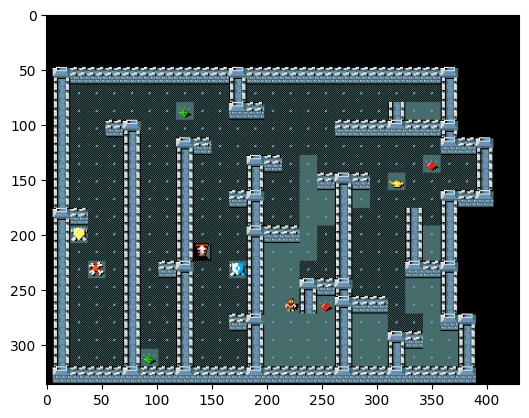

In [2]:
from src.explore_room import *

env, goals_info = generate_env()

guessed_room = exhaustive_exploration(env.reset(), env)

if goals_info[guessed_room][3] == 'uncursed':
    print("Win")
else:
    print("Lose")

<h3>Find a new target during the exploration</h3>


<h3>Conditioned map</h3>
During the exploration, at each iteration, the A* algorithm is invoked for finding the shortest path between the agent position and a selected target. Instead of the original game map, A* operates on a pre-conditioned map created by us. The pre-conditioned map is generated by adding "fake walls" along all paths adjacent to the walls, ensuring that these additions do not block any path.
The A* algorithm works on the conditioned map and returns a path constantly 1 cell away from the walls of the original game map. Since the agent can perceive adjacent cells, moving to a cell next to the wall would be unnecessary, as it can still be observed with one step less.
Therefore, the conditioned map allows visiting the entire area while reducing the number of unnecessary cells to traverse.


<h3>A* optimization</h3>

During exploration, there are cases where calling A* is unnecessary since the path is simply a straight line between the two cells (agent position and target). These instances can be easily detected by checking the coordinates of the two cells. When this case is identified, A* is not executed; instead, the algorithm simply returns the path that corresponds to a straight line from agent position to target. 
This optimization reduces the number of calls to A*, thereby improving the algorithm's performance in time and space.

<h3>TEST</h3>

<h3>CONCLUSIONS</h3>